# Introduction

In this notebook we want to investigate the relative phase between modes.

- what is the best way to compute them. either from the phase or from the ratio of complex strain?

- check that they are invariant under time and phase shifts

In [88]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")


In [89]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})

<Figure size 640x480 with 0 Axes>

In [90]:
import waveform_utils
import waveform_generator
import hybrid_utils

In [91]:
import spliced_pn

In [92]:
import lalsimulation as lalsim

In [93]:
import numpy as np
import copy

In [94]:
def delta_phi_fn(m, return_complex=False):
    """
    leading order PN imaginary part of complex amplitude
    """
    z = (-1)*(-1.j)**m
    if return_complex:
        return z
    else:
        return np.arctan2(z.imag, z.real)

In [95]:
import os
# download HybSur data file: https://git.ligo.org/lscsoft/lalsuite-extra/-/blob/master/data/lalsimulation/NRHybSur3dq8_lal.h5
# set path
os.environ['LAL_DATA_PATH'] = '/Users/sebastian.khan/Downloads/'

In [122]:
# load_wf = 'nr'
load_wf = 'approx'
# load_wf = 'spliced'
# only one allowed

#########################
###### load nr or...
#########################

if load_wf == 'nr':
    
    modes=[(2,2),(2,1),(3,3),(3,2),(4,4),(4,3)]
    
    # nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res4.h5" #q=1
    nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res3.h5" #q=2
    # nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res5.h5" #q=4
    # nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0107_Res5.h5" #q=5
    # nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0063_Res5.h5" #q=8
    # nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0303_Res3.h5" #q=10
    # nr_hdf5_filename="/Users/sebastian.khan/Downloads/MAYA0909.h5"
    # sample spacing in units of M for output NR time series
    delta_t=0.1
    wf = waveform_generator.get_hdf5_strain(nr_hdf5_filename, modes, delta_t)
    print(wf['metadata'])
    q = wf['metadata']['q']
    
    # stupid trick to change modes if we have equal mass-case
    # we re-load the data
    if np.isclose(q, 1):
        modes = [(2,2),(3,2),(4,4)]
        wf = waveform_generator.get_hdf5_strain(nr_hdf5_filename, modes, delta_t)

#########################
##### load approximant
#########################

elif load_wf == 'approx':
    
    q=2
    modes=[(2,2),(2,1),(3,3),(3,2),(4,4),(4,3)]
    # modes=[(2,2),(2,1),(3,3),(4,4)]
    # modes=[(2,2),(2,1),(3,3)]
    # approximant=lalsim.SEOBNRv4PHM
    # approximant=lalsim.SpinTaylorT1
    # approximant=lalsim.TaylorT1
    approximant=lalsim.NRHybSur3dq8
    wf = waveform_generator.generate_waveform(
        q,
        modes,
        approximant=approximant,
        f_min=20,
        deltaT=1/4096,
    )

elif load_wf == 'spliced':
    q=2
    modes=[(2,2),(2,1),(3,3),(3,2),(4,4),(4,3)]
    wf = spliced_pn.generate_spliced_pn_waveform(q, modes, f_min=20, deltaT=1/4096)
wf = waveform_utils.Waveform(wf['t'], wf['hlm'])
t0, _ = (
    wf
        # .mask(-600)
        .compute_amplitude()
        .compute_phase()
        .compute_frequency()
        .compute_time_of_peak()
)

In [123]:
wf

In [124]:
t0

-0.47043888375474185

In [125]:
load_wf

'approx'

In [126]:
delta_phi_fn(1)

1.5707963267948966

In [127]:
delta_phi_fn(1, return_complex=True)

1j

In [128]:
###
# from https://git.ligo.org/hector.estelles/waveform-conventions/-/tree/master/

def UIBMod(xarray, angle):

	""" It is simply a custom modulo function """

	ret = np.zeros(len(xarray))
	for i, x in enumerate(xarray):
	    mod = x%angle
    
	    if mod>angle/2:
	        ret[i] = mod - angle
	    else:
	        ret[i] = mod
	return ret


In [148]:
def compare_phase(wf, l, m, apply_pn_shift=True, test_tetrad=False):
    if test_tetrad:
        t0 = wf.phases[l, m] * 2
        t1 = wf.phases[2,2]  * m
    else:
        t0 = wf.phases[l, m]
        t1 = wf.phases[2,2]/2 * m
    if apply_pn_shift:
        return  t0 - t1 - delta_phi_fn(m)
    else:
        return  t0 - t1

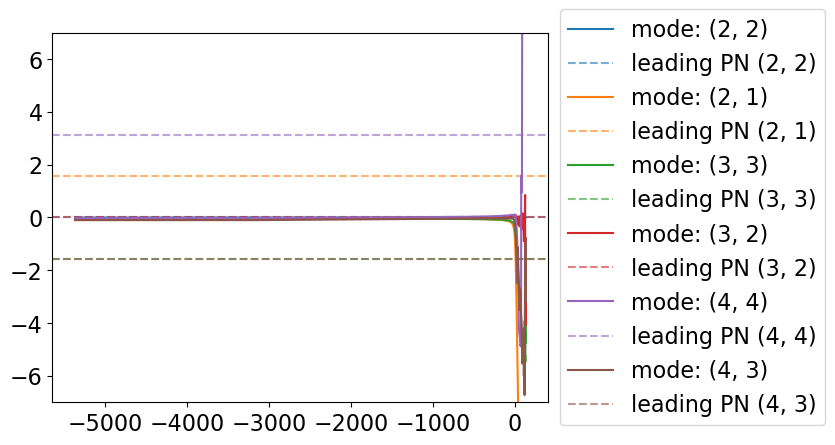

In [149]:
for i, (l, m) in enumerate(wf.modes):
    plt.plot(wf.times, compare_phase(wf, l, m), label=f"mode: {l,m}", c=f"C{i}")
    plt.axhline(delta_phi_fn(m), ls='--', alpha=0.6, label=f"leading PN {l,m}", c=f"C{i}")
# plt.ylim(-1, 1)
plt.ylim(-7, 7)
# plt.axhline(2*np.pi)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

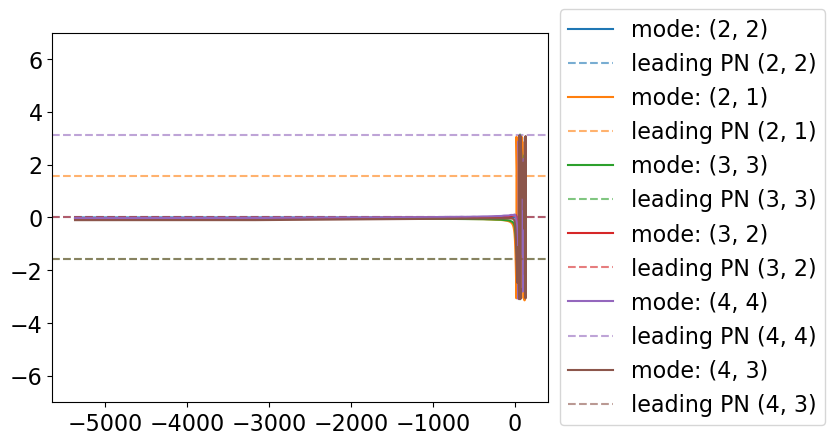

In [150]:
for i, (l, m) in enumerate(wf.modes):
    plt.plot(wf.times, UIBMod(compare_phase(wf, l, m), 2*np.pi), label=f"mode: {l,m}", c=f"C{i}")
    plt.axhline(delta_phi_fn(m), ls='--', alpha=0.6, label=f"leading PN {l,m}", c=f"C{i}")
# plt.ylim(-1, 1)
plt.ylim(-7, 7)
# plt.axhline(2*np.pi)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

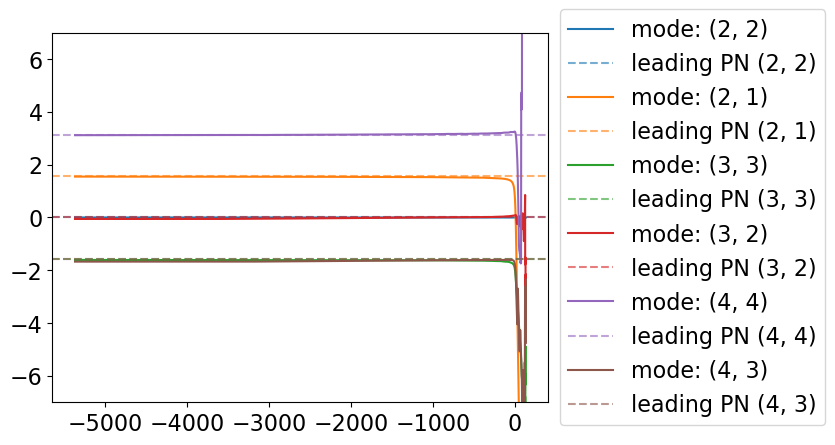

In [151]:
for i, (l, m) in enumerate(wf.modes):
    plt.plot(wf.times, compare_phase(wf, l, m, apply_pn_shift=False), label=f"mode: {l,m}", c=f"C{i}")
    plt.axhline(delta_phi_fn(m), ls='--', alpha=0.6, label=f"leading PN {l,m}", c=f"C{i}")
# plt.ylim(-1, 1)
plt.ylim(-7, 7)
# plt.axhline(2*np.pi)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

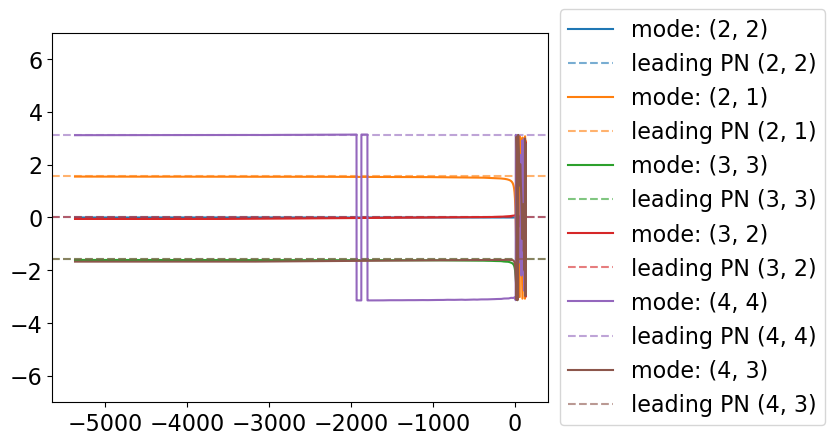

In [152]:
for i, (l, m) in enumerate(wf.modes):
    plt.plot(wf.times, UIBMod(compare_phase(wf, l, m, apply_pn_shift=False), 2*np.pi), label=f"mode: {l,m}", c=f"C{i}")
    plt.axhline(delta_phi_fn(m), ls='--', alpha=0.6, label=f"leading PN {l,m}", c=f"C{i}")
# plt.ylim(-1, 1)
plt.ylim(-7, 7)
# plt.axhline(2*np.pi)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [153]:
def compare_phase_via_hlms(wf, l, m, apply_pn_shift=True, test_tetrad=False):


    if test_tetrad:
        t0 = np.unwrap(np.angle(wf.hlms[l, m])) * 2
        t1 = np.unwrap(np.angle(wf.hlms[2,2]))  * m
    else:
        t0 = np.unwrap(np.angle(wf.hlms[l, m]))
        t1 = np.unwrap(np.angle(wf.hlms[2,2]))/2 * m

    if apply_pn_shift:
        return  t0 - t1 - delta_phi_fn(m)
    else:
        return  t0 - t1

In [154]:
wf.phases[2,2][0]/2

-0.0

In [155]:
wf.phases[2,1][0]/2

0.7743584235662339

In [156]:
# _phase_orb_shift = -np.mod(_phase_22_/2, 2*np.pi)

In [157]:
wf.phases[2,2][0]/2

-0.0

In [158]:
wf.apply_phase_shift(-wf.phases[2,2][0]/2)
# wf.apply_phase_shift(-wf.phases[2,1][0])
# wf.compute_phase()

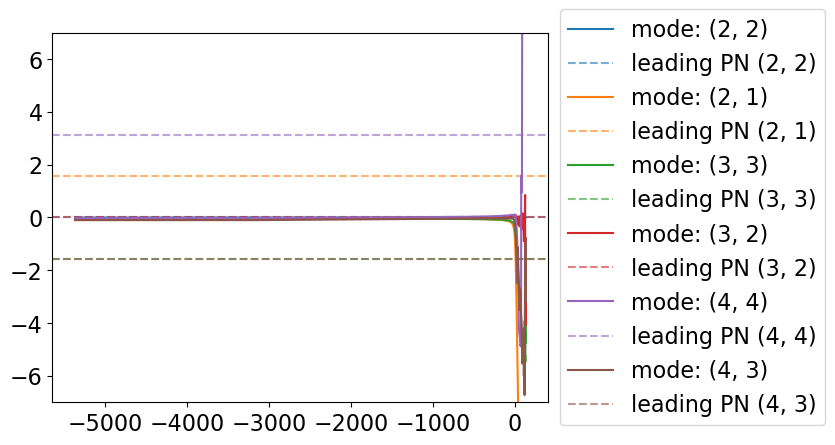

In [159]:
for i, (l, m) in enumerate(wf.modes):
    plt.plot(wf.times, compare_phase_via_hlms(wf, l, m), label=f"mode: {l,m}", c=f"C{i}")
    plt.axhline(delta_phi_fn(m), ls='--', alpha=0.6, label=f"leading PN {l,m}", c=f"C{i}")
# plt.ylim(-1, 1)
plt.ylim(-7, 7)
# plt.axhline(2*np.pi)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

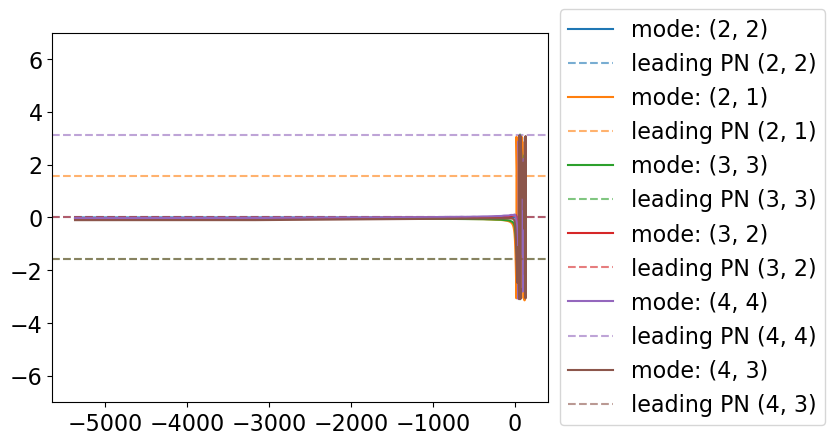

In [160]:
for i, (l, m) in enumerate(wf.modes):
    plt.plot(wf.times, UIBMod(compare_phase_via_hlms(wf, l, m), 2*np.pi), label=f"mode: {l,m}", c=f"C{i}")
    plt.axhline(delta_phi_fn(m), ls='--', alpha=0.6, label=f"leading PN {l,m}", c=f"C{i}")
# plt.ylim(-1, 1)
plt.ylim(-7, 7)
# plt.axhline(2*np.pi)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

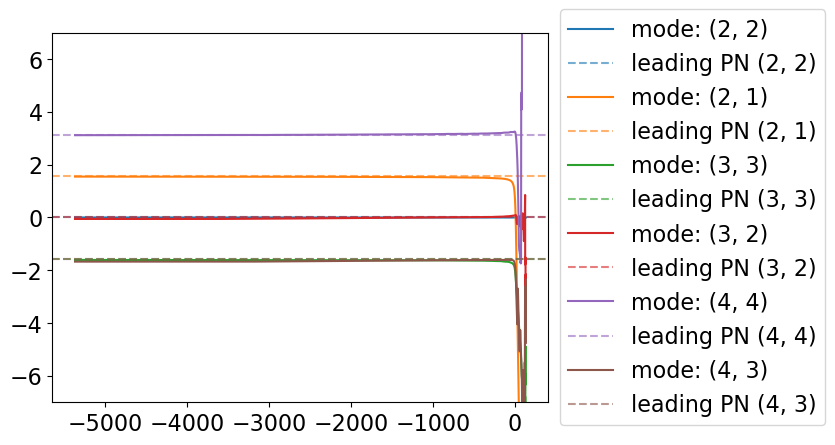

In [161]:
for i, (l, m) in enumerate(wf.modes):
    plt.plot(wf.times, compare_phase_via_hlms(wf, l, m, apply_pn_shift=False), label=f"mode: {l,m}", c=f"C{i}")
    plt.axhline(delta_phi_fn(m), ls='--', alpha=0.6, label=f"leading PN {l,m}", c=f"C{i}")
# plt.ylim(-1, 1)
plt.ylim(-7, 7)
# plt.axhline(2*np.pi)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

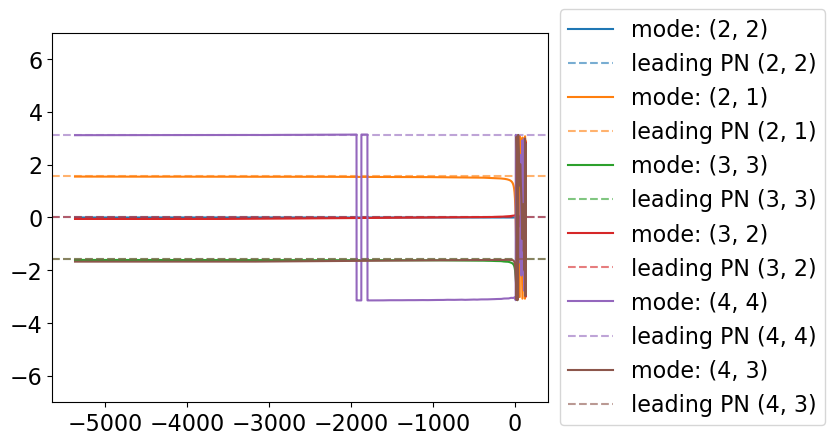

In [162]:
for i, (l, m) in enumerate(wf.modes):
    plt.plot(wf.times, UIBMod(compare_phase_via_hlms(wf, l, m, apply_pn_shift=False), 2*np.pi), label=f"mode: {l,m}", c=f"C{i}")
    plt.axhline(delta_phi_fn(m), ls='--', alpha=0.6, label=f"leading PN {l,m}", c=f"C{i}")
# plt.ylim(-1, 1)
plt.ylim(-7, 7)
# plt.axhline(2*np.pi)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# compute match between phase shifted waveforms

requires summing modes

In [118]:
def sum_modes_hack(wf):
    return np.sum([wf.hlms[mode] for mode in wf.modes], 0)

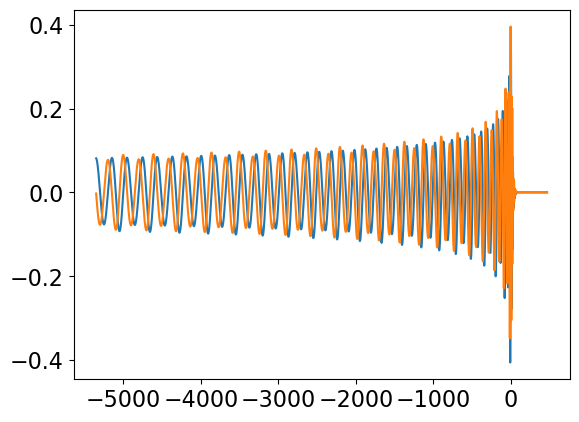

In [119]:
plt.plot(wf.times, np.real(sum_modes_hack(wf)))
plt.plot(wf.times, np.imag(sum_modes_hack(wf)))